In [11]:
from model.MultiBranch import MultiBranchModel
from helpers.Trainer import Trainer
from helpers.Tester import Tester
from helpers.YoutubeDataset import YoutubeDataset
from helpers.EarlyStopping import EarlyStopping
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# Load data

In [2]:
train_data = pd.read_csv('data/train_data.csv')
val_data = pd.read_csv('data/val_data.csv')
test_data = pd.read_csv('data/test_data.csv')
train_data.head()

,ytvideoid,views,comments,likes,dislikes,timestamp
0,1,472549,3887,72559,1339,2019-11-25 17:30:00
1,1,472549,4026,74427,1365,2019-11-25 18:00:00
2,1,472549,4150,76092,1388,2019-11-25 18:30:00
3,1,485143,4235,77472,1420,2019-11-25 19:00:00
4,1,532254,4334,78655,1443,2019-11-25 19:30:00


In [3]:
feature_cols = ['views', 'comments', 'likes', 'dislikes'] 

scaler = StandardScaler()

scaler.fit(train_data[feature_cols])

train_scaled = train_data.copy()
train_scaled[feature_cols] = scaler.transform(train_data[feature_cols])

val_scaled = val_data.copy()
val_scaled[feature_cols] = scaler.transform(val_data[feature_cols])

test_scaled = test_data.copy()
test_scaled[feature_cols] = scaler.transform(test_data[feature_cols])

train_scaled.head()

,ytvideoid,views,comments,likes,dislikes,timestamp
0,1,-0.405903,-0.157636,-0.160458,-0.040363,2019-11-25 17:30:00
1,1,-0.405903,-0.154329,-0.153561,-0.040076,2019-11-25 18:00:00
2,1,-0.405903,-0.151378,-0.147413,-0.039823,2019-11-25 18:30:00
3,1,-0.403192,-0.149355,-0.142317,-0.039470,2019-11-25 19:00:00
4,1,-0.393049,-0.146999,-0.137949,-0.039217,2019-11-25 19:30:00


In [4]:
seq_len = 10
forecast_horizon = 1
batch_size = 128

train_dataset = YoutubeDataset(
    df=train_scaled,
    features=feature_cols,
    target='views',
    seq_len=seq_len,
    forecast_horizon=forecast_horizon
)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

In [5]:
val_dataset = YoutubeDataset(
    df=val_scaled,
    features=feature_cols,
    target='views',
    seq_len=seq_len,
    forecast_horizon=forecast_horizon
)
test_dataset = YoutubeDataset(
    df=test_scaled,
    features=feature_cols,
    target='views',
    seq_len=seq_len,
    forecast_horizon=forecast_horizon
)

In [6]:
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train

In [7]:
model = MultiBranchModel(
    input_size=len(feature_cols),
    hidden_size={'lstm': 50, 'gru': 50},
    num_layers={'lstm': 1, 'gru': 1},
    dropout={'lstm': 0.3, 'gru': 0.3},
    output_size=1
)

d:\Programacion\Multibranch-TimeSeries-NN\.venv\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [8]:
import torch.optim as optim
import torch.nn as nn
import torch

optimizer = optim.Adam(model.parameters(), lr=0.001) 
loss_fn = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {device.type}')

early_stopping = EarlyStopping(patience = 30,
                               min_delta = 0.0001,
                               verbose = True,
                               path = "best_model.pt")

trainer = Trainer(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device,
    early_stopping=early_stopping
)

DEVICE: cpu


In [9]:
epochs = 5000
train_loss, val_loss = trainer.fit(train_loader=train_loader, val_loader=val_loader, epochs=epochs)

Starting training.


Epoch [1/5000] | Training Loss: 0.0163 | Validation Loss: 0.0001
Validation loss improved to 0.0001


No improvement in validation loss [1/30]


No improvement in validation loss [2/30]


No improvement in validation loss [3/30]


No improvement in validation loss [4/30]


No improvement in validation loss [5/30]


No improvement in validation loss [6/30]


No improvement in validation loss [7/30]


No improvement in validation loss [8/30]


No improvement in validation loss [9/30]


Epoch [11/5000] | Training Loss: 0.0004 | Validation Loss: 0.0000
No improvement in validation loss [10/30]


No improvement in validation loss [11/30]


No improvement in validation loss [12/30]


No improvement in validation loss [13/30]


No improvement in validation loss [14/30]


No improvement in validation loss [15/30]


No improvement in validation loss [16/30]


No improvement in validation loss [17/30]


No improvement in validation loss [18/30]


No improvement in validation loss [19/30]


Epoch [21/5000] | Training Loss: 0.0003 | Validation Loss: 0.0001
No improvement in validation loss [20/30]


No improvement in validation loss [21/30]


No improvement in validation loss [22/30]


No improvement in validation loss [23/30]


No improvement in validation loss [24/30]


No improvement in validation loss [25/30]


No improvement in validation loss [26/30]


No improvement in validation loss [27/30]


No improvement in validation loss [28/30]


No improvement in validation loss [29/30]


Epoch [31/5000] | Training Loss: 0.0003 | Validation Loss: 0.0001
No improvement in validation loss [30/30]
Early stopping triggered.


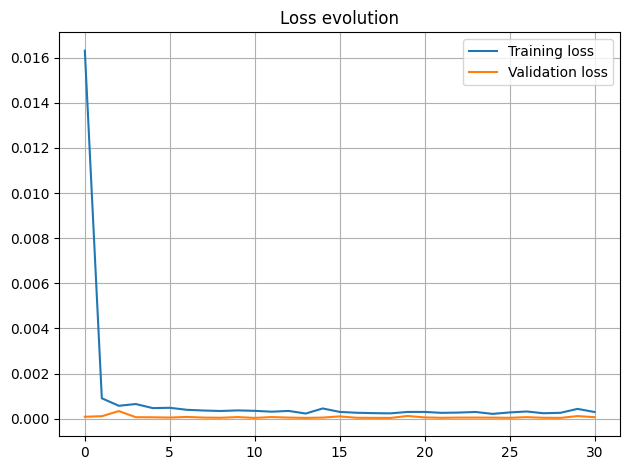

In [10]:
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Loss evolution')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


In [ ]:
model = MultiBranchModel()
model.load_state_dict(torch.load('best_model.pt', weights_only=False))
print(model)
tester = Tester(model=model, loss_fn=loss_fn, device=device)
metrics = tester.evaluate(dataloader = test_loader)
metrics

OrderedDict([('lstm.lstm.weight_ih_l0', tensor([[-6.1349e-02,  1.0519e-01, -1.2638e-01, -8.0523e-02],
        [ 1.0565e-03,  7.4191e-02,  6.7464e-03,  1.1460e-01],
        [ 7.0609e-02,  7.1568e-03, -2.5537e-02, -7.2762e-02],
        [-4.2496e-02, -1.3873e-03,  3.5808e-02,  6.1052e-02],
        [ 8.4082e-02,  8.8876e-02, -1.0159e-01, -9.2291e-02],
        [ 3.9678e-02,  7.4321e-02, -8.9867e-02,  1.6568e-01],
        [ 2.5966e-02,  1.8193e-02,  1.2550e-01, -1.1526e-01],
        [-6.1894e-02,  2.5284e-02, -1.4430e-02,  1.5794e-01],
        [-2.3855e-02, -1.2546e-03, -3.1473e-02, -4.6546e-04],
        [ 4.3978e-03,  1.9436e-01,  9.6985e-02,  2.8854e-01],
        [ 8.8843e-02, -9.7303e-03,  7.2056e-02,  2.4737e-02],
        [-5.7049e-02, -1.9864e-02,  1.3408e-01,  5.9580e-02],
        [-1.7061e-02,  4.2593e-02,  1.0493e-01,  1.3139e-01],
        [-4.0512e-03,  3.1471e-02,  6.5760e-02, -9.0935e-02],
        [ 1.0759e-01, -3.0645e-02, -1.4097e-02,  4.1101e-02],
        [ 1.1020e-01,  8.4596e

AttributeError: 'collections.OrderedDict' object has no attribute 'to'